In [33]:
import sys
sys.path.append('/Users/laurenthericourt/projets/trading/trading')
import warnings
warnings.filterwarnings('ignore')
import re
import random

import psycopg2
import numpy as np
import pandas as pd
from pandas.io.sql import read_sql
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
from tqdm import tqdm
import yfinance as yf
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from config.load import load_conf
from db.utils import get_uri_db
from utils.utils import AnnualGranularity, get_candles
from indicator.oscillator import Atr, Macd, Rsi, Stochastic, Obv
from indicator.trend import BollingerBands, Adx, Slope, MovingAverage, HullMovingAverage

In [2]:
load_conf('../config/configuration.yaml')
dsn = get_uri_db()
schema = 'trading'

# Get data

In [3]:
start_date = '2015-01-01'
end_date = '2021-01-01'

all_candles = get_candles(dsn, schema, start_date, end_date)

In [7]:
candles = all_candles[(all_candles['table'] == 'candle') & (all_candles['symbol'] == 'EUR/USD')]

In [5]:
with psycopg2.connect(dsn) as conn:
    sql = f'''set search_path to trading;'''
    sql += f'''
        SELECT *
        FROM event
        WHERE date >= %(start_date)s and date < %(end_date)s 
        order by date
    '''
    events = read_sql(sql, conn, params={'start_date': start_date, 'end_date': end_date})
events.reset_index(drop=True, inplace=True)

In [6]:
events.head()

id                       created_at  \
0  8752f12d-a81b-4244-90f6-61a477fd57e4 2020-12-23 12:11:01.614935+00:00   
1  7ead99ee-2ce6-4b90-aa94-27f68eaa6f69 2020-12-23 12:11:01.614935+00:00   
2  484a49ae-9073-42ab-adfc-7805d0bbcdd0 2020-12-23 12:11:01.614935+00:00   
3  b3c1728d-982b-4d8e-8f21-3412a1f0594f 2020-12-23 12:11:01.614935+00:00   
4  3ac6c44c-25a3-4aa1-8513-8f42f515b118 2020-12-23 12:11:01.614935+00:00   

                 date country  importance                          name  \
0 2015-01-01 06:30:00     AUD           2  Indice AUD/USD Investing.com   
1 2015-01-01 06:30:00     CAD           2  Indice USD/CAD Investing.com   
2 2015-01-01 06:30:00     CHF           2  Indice USD/CHF Investing.com   
3 2015-01-01 06:30:00     EUR           2  Indice EUR/USD Investing.com   
4 2015-01-01 06:30:00     GBP           2  Indice GBP/USD Investing.com   

   actual_value  is_positive  forecast_value  previous_value  
0          58.9            0             NaN            57.0  
1          44.1            0             NaN            48.4  
2          56.7            0             NaN            47.7  
3          40.6            0             NaN            45.2  
4          54.5            0             NaN            51.2

In [13]:
months = ['(jan.)', '(févr.)', '(mar)', '(avr)', '(mai)', '(juin)', '(juill.)', '(août)', '(sept.)', '(oct.)', '(nov.)', '(déc)']
regex_month = re.compile(r'|'.join(months).replace('(', '\(').replace(')', '\)').replace('.', '\.'))

periods = [' (t1)', ' (t2)', ' (t3)', ' (t4)', ' m1', ' m2', ' m3', ' m4', ' m5', ' m6', ' m7', ' m8', ' m9', ' m10', ' m11', ' m12']
regex_period = re.compile(r'|'.join(periods).replace('(', '\(').replace(')', '\)'))

events['processed_name'] = events['name'].str.lower()
events['processed_name'] = events['processed_name'].str.replace(regex_month, '')
events['processed_name'] = events['processed_name'].str.replace(regex_period, '')
events['processed_name'] = events['processed_name'].str.strip()

In [20]:
events_eur = events[(events['country'] == 'EUR') & (events['importance'] == 1)]
events_usd = events[(events['country'] == 'USD') & (events['importance'] == 1)]

In [21]:
events_eur['importance'].value_counts()

1    1771
Name: importance, dtype: int64

In [23]:
events_eur.head()

id                       created_at  \
36   320afcf8-d728-468f-8ddc-0864d12077db 2020-12-23 12:11:01.614935+00:00   
87   987c45df-fef7-4bd5-a7e3-ea987f5cab7b 2020-12-23 12:11:01.614935+00:00   
114  6c76438b-aa3e-4424-bcf0-d90ebf2ba7d5 2020-12-23 12:11:01.614935+00:00   
115  11ce9304-e38f-47ae-8100-3668f9c91bd1 2020-12-23 12:11:01.614935+00:00   
116  963b72a7-bcd6-431d-938b-0a94ebf06eed 2020-12-23 12:11:01.614935+00:00   

                   date country  importance  \
36  2015-01-05 09:30:00     EUR           1   
87  2015-01-07 09:10:00     EUR           1   
114 2015-01-08 10:00:00     EUR           1   
115 2015-01-08 10:00:00     EUR           1   
116 2015-01-08 10:00:00     EUR           1   

                                                  name  actual_value  \
36   Indice Sentix de confiance des investisseurs  ...           0.9   
87                     Indice PMI des ventes au détail          47.6   
114                         Climat des affaires  (Déc)           0.0   
115                 Confiance des consommateurs  (Déc)         -11.0   
116  Enquête de confiance des consommateurs et des ...         100.7   

     is_positive  forecast_value  previous_value  \
36             1            -1.0            -2.5   
87             0             NaN            48.9   
114           -1             0.2             0.2   
115           -1           -10.9           -12.0   
116           -1           101.2           100.7   

                                        processed_name  
36        indice sentix de confiance des investisseurs  
87                     indice pmi des ventes au détail  
114                                climat des affaires  
115                        confiance des consommateurs  
116  enquête de confiance des consommateurs et des ...

In [101]:
events_usd.loc[(events_usd['importance'] == 1) & (events_usd['is_positive'] != 0), 'processed_name'].value_counts()

stocks hebdomadaires de produits distillés eia                           312
stocks d'essence                                                         312
bénéficiaires réguliers de l'allocation chômage                          303
stocks de gaz naturel                                                    298
indice michigan - situation économique actuelle                          128
stocks de grossistes (mensuel)                                            87
crédit à la consommation                                                  72
ipc (non cvs)                                                             72
commandes de biens durables hors défense et aéronautique (mensuel)        70
dépenses de construction (mensuel)                                        70
créations d'emplois dans le secteur manufacturier                         70
ism non manufacturier - activité                                          69
ism manufacturier - prix payés                                            68

# Check correlation

In [105]:
def show_random_cases(candles, events, nb_examples_to_show=30, nb_candles_to_show=50, positiv=1):
    ev = events[events['is_positive'] == positiv].copy().reset_index(drop=True)
    idx = ev.index.tolist()
    #idx = candles[candles['atr'] < candles['range_bb'] / 4].index.tolist()
    random.shuffle(idx)

    idx_to_show = idx[:nb_examples_to_show]
    #range_of_idx_to_show = [(x - nb_candles_to_show // 2, x + nb_candles_to_show // 2) for x in idx_to_show]
    
    for i, idx_event in enumerate(idx_to_show):
        date = str(ev.loc[idx_event, 'date'])
        idx_candle = candles.loc[candles['date'] == date].index.tolist()[0]
        candles_to_show = candles.loc[idx_candle - nb_candles_to_show // 2 : idx_candle + nb_candles_to_show // 2]
        print(ev.loc[idx_event, ['actual_value', 'forecast_value', 'previous_value']])    
        if i % 2 == 0:
            fig = make_subplots(rows=1, cols=2)
        
        fig.update_layout(xaxis1_rangeslider_visible=False, xaxis2_rangeslider_visible=False)

        width = 2
        color = 'rgba(46, 134, 193, 0.5)'
        fig.add_trace(go.Candlestick(x=candles_to_show['date'],
                                     open=candles_to_show['open'],
                                     high=candles_to_show['high'],
                                     low=candles_to_show['low'],
                                     close=candles_to_show['close']),
                      row=1, col= i % 2 + 1)        

        fig.add_vline(x=date, line_dash='dot', line_color='blue', row=1, col= i % 2 + 1)


        if i % 2 == 1:
            fig.show()

In [106]:
event_name = "bénéficiaires réguliers de l'allocation chômage"
data = events_usd

data = data[data['processed_name'] == event_name]

In [107]:
data.shape

(313, 11)

actual_value      1952
forecast_value    1900
previous_value    1876
Name: 76, dtype: object
actual_value      2452
forecast_value    2368
previous_value    2351
Name: 0, dtype: object


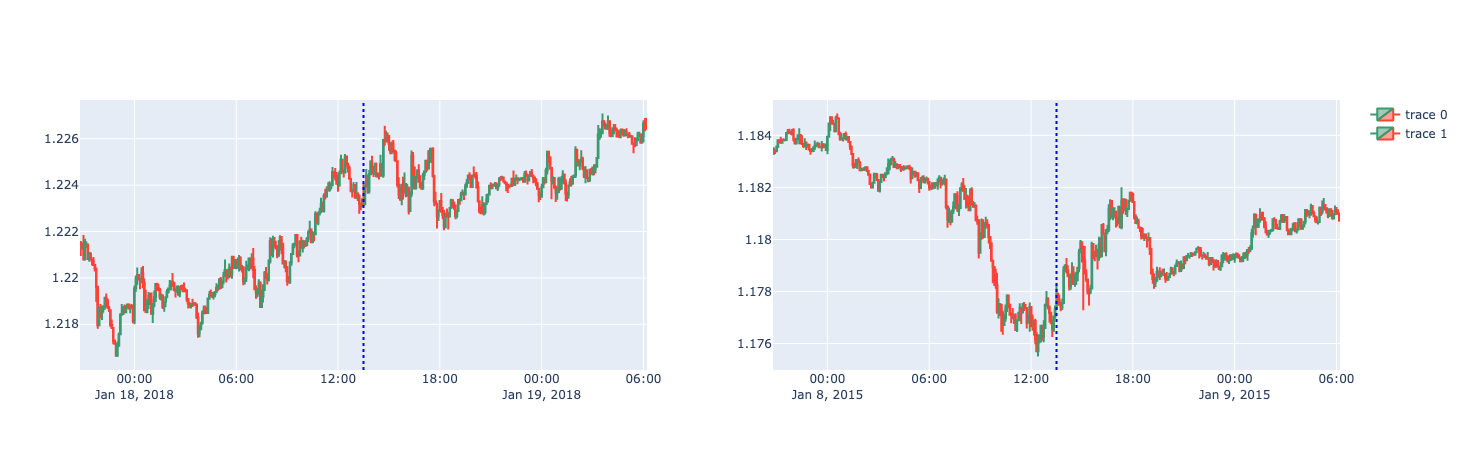

actual_value      1726
forecast_value    1690
previous_value    1687
Name: 113, dtype: object
actual_value      19290
forecast_value    19000
previous_value    19231
Name: 133, dtype: object


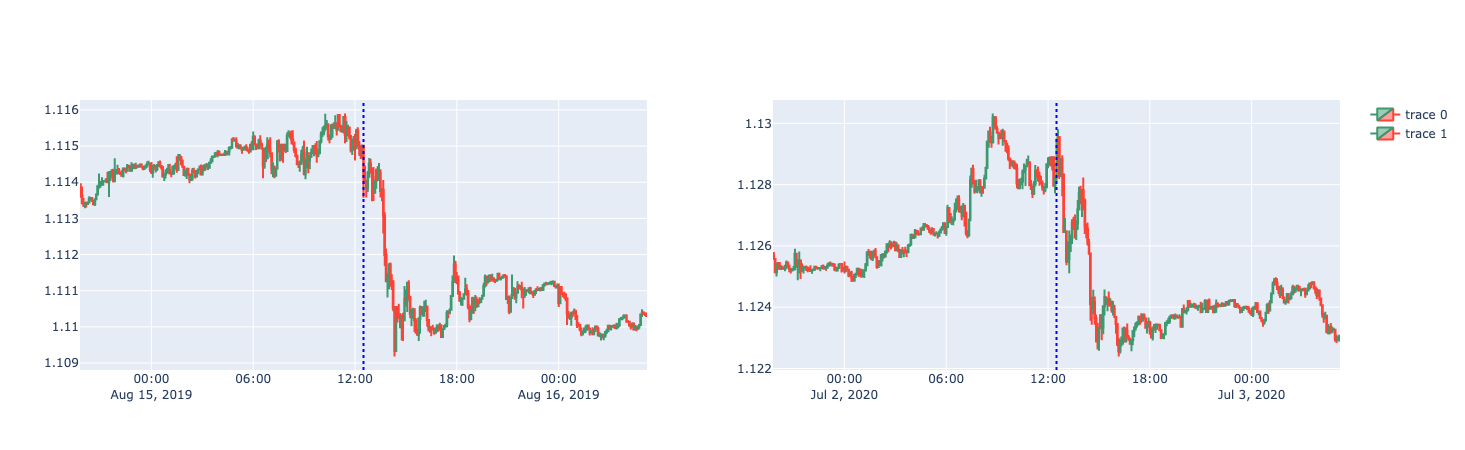

actual_value      1767
forecast_value    1720
previous_value    1804
Name: 124, dtype: object
actual_value      1695
forecast_value    1680
previous_value    1693
Name: 108, dtype: object


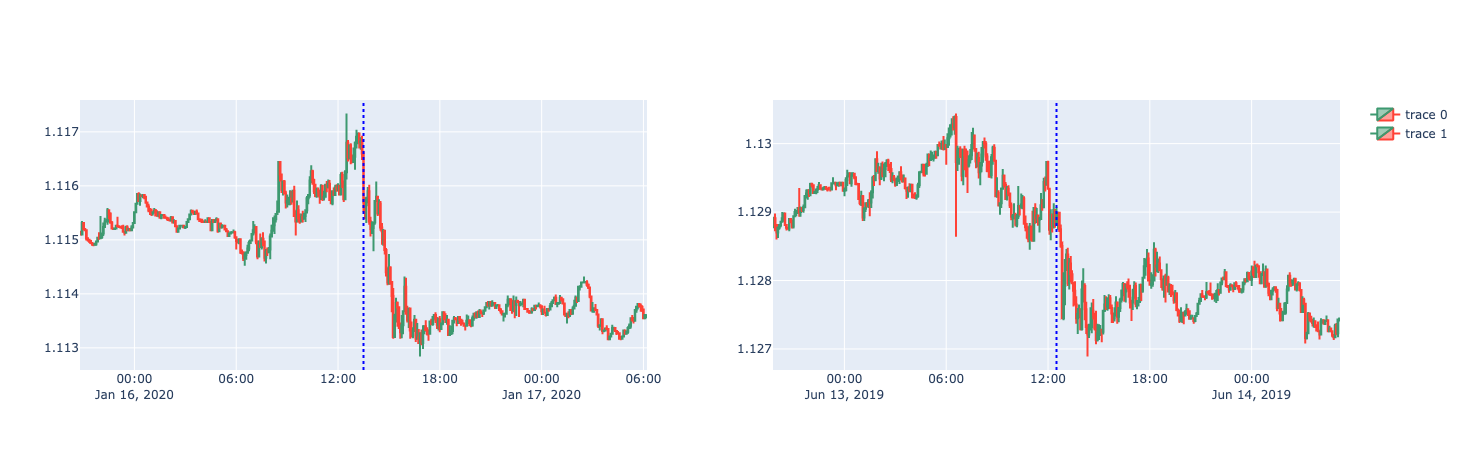

actual_value      14535
forecast_value    14450
previous_value    14758
Name: 135, dtype: object
actual_value      2057
forecast_value    2050
previous_value    2050
Name: 50, dtype: object


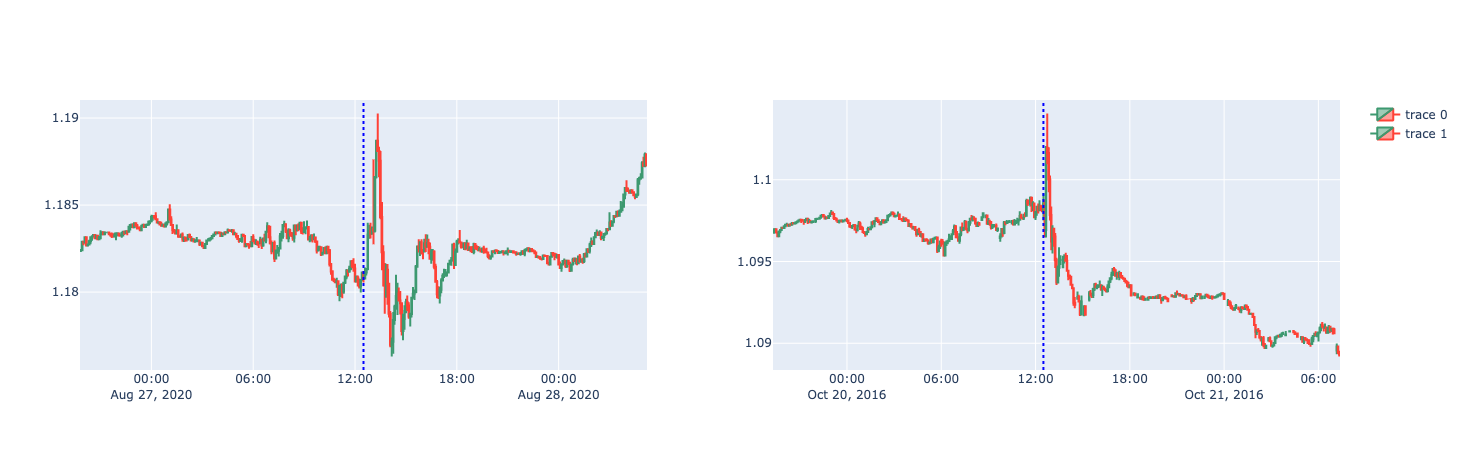

actual_value      1932
forecast_value    1900
previous_value    1889
Name: 74, dtype: object
actual_value      2222
forecast_value    2208
previous_value    2211
Name: 11, dtype: object


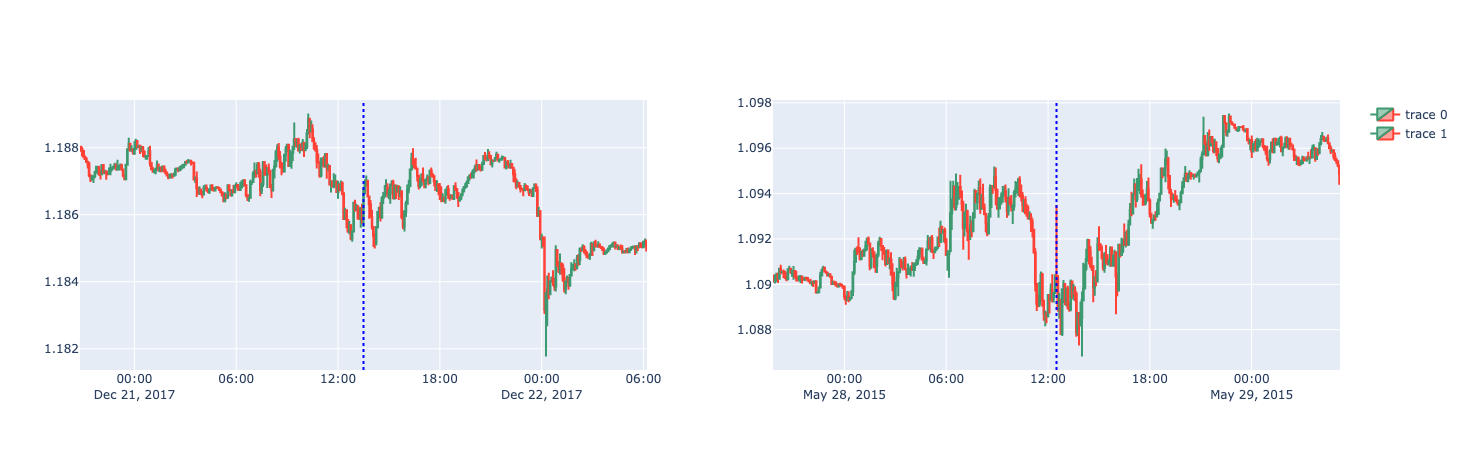

actual_value      2102
forecast_value    2030
previous_value    2039
Name: 55, dtype: object
actual_value      1726
forecast_value    1720
previous_value    1701
Name: 126, dtype: object


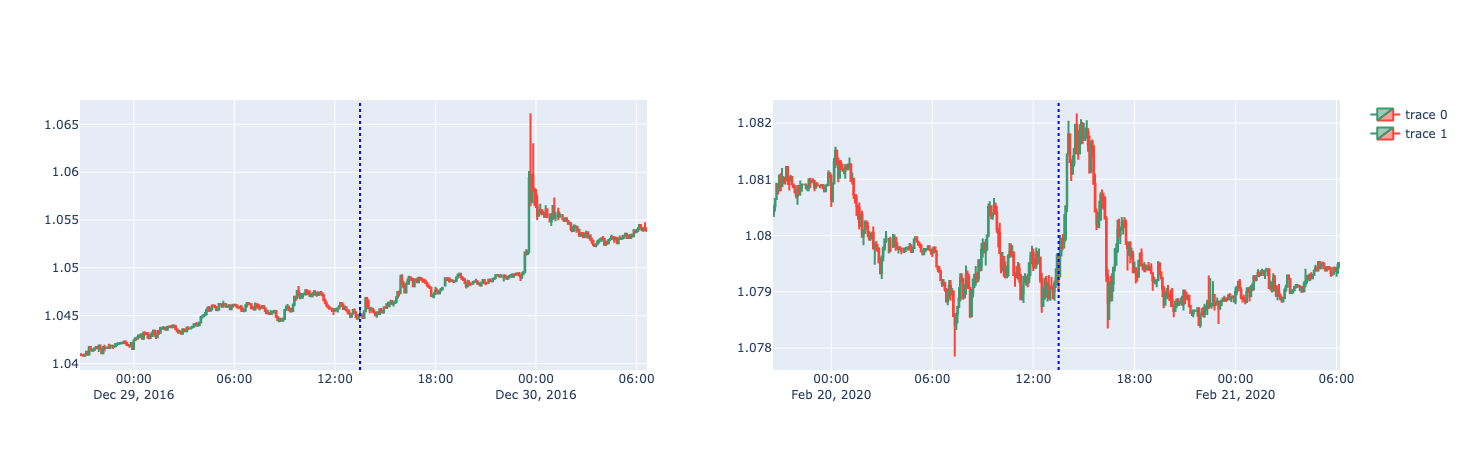

actual_value      2417
forecast_value    2410
previous_value    2428
Name: 8, dtype: object
actual_value      1698
forecast_value    1680
previous_value    1676
Name: 114, dtype: object


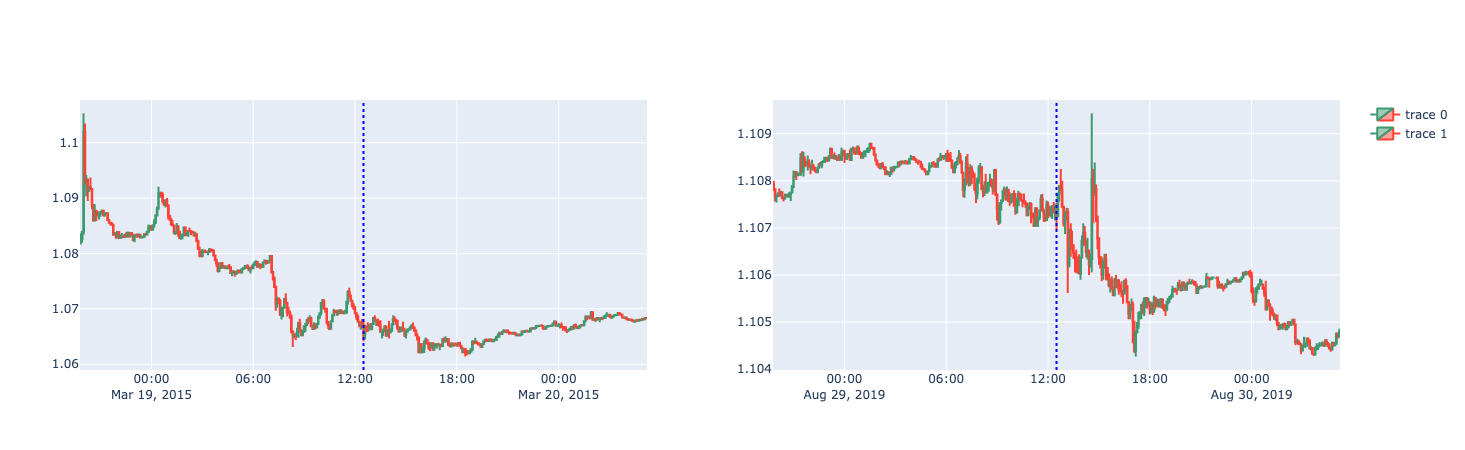

actual_value      1661
forecast_value    1650
previous_value    1636
Name: 93, dtype: object
actual_value      2124
forecast_value    2113
previous_value    2168
Name: 42, dtype: object


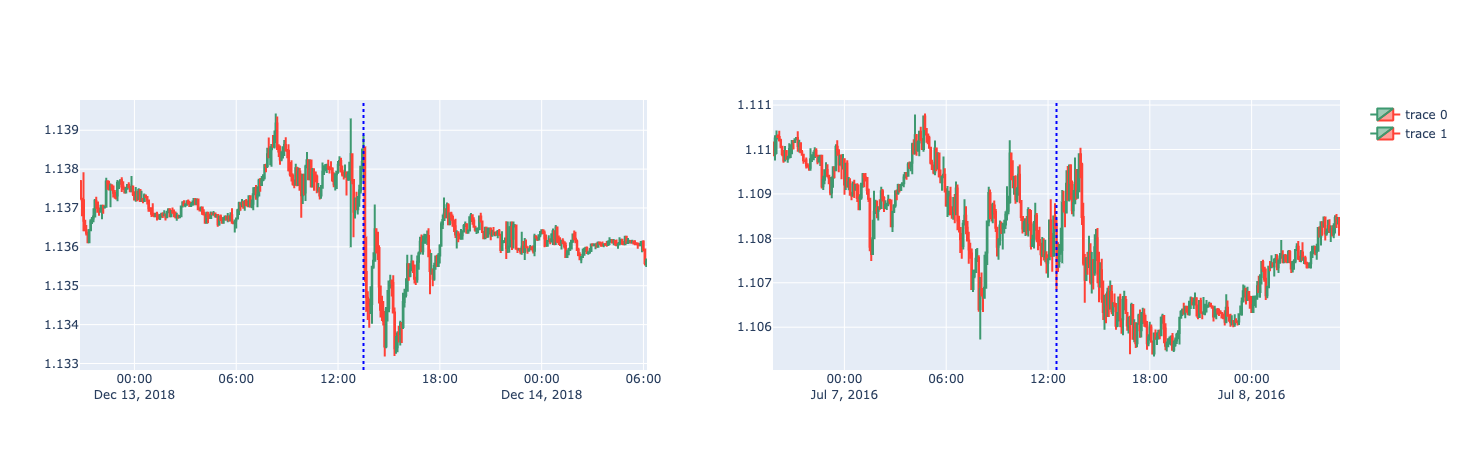

actual_value      2149
forecast_value    2128
previous_value    2117
Name: 43, dtype: object
actual_value      1710
forecast_value    1664
previous_value    1660
Name: 92, dtype: object


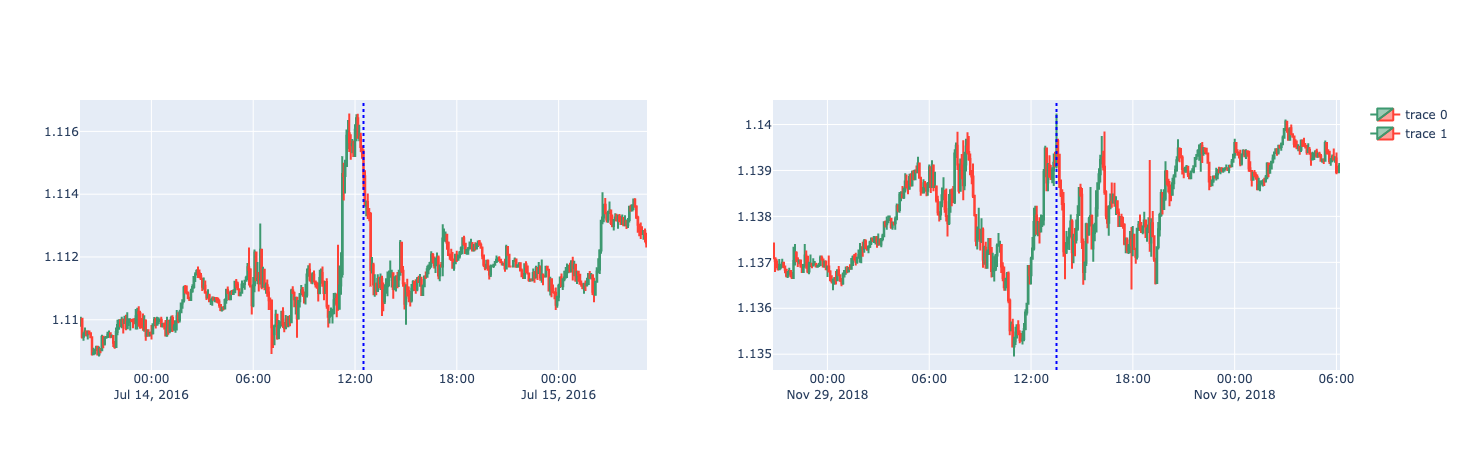

actual_value      2325
forecast_value    2300
previous_value    2275
Name: 10, dtype: object
actual_value      1690
forecast_value    1680
previous_value    1683
Name: 118, dtype: object


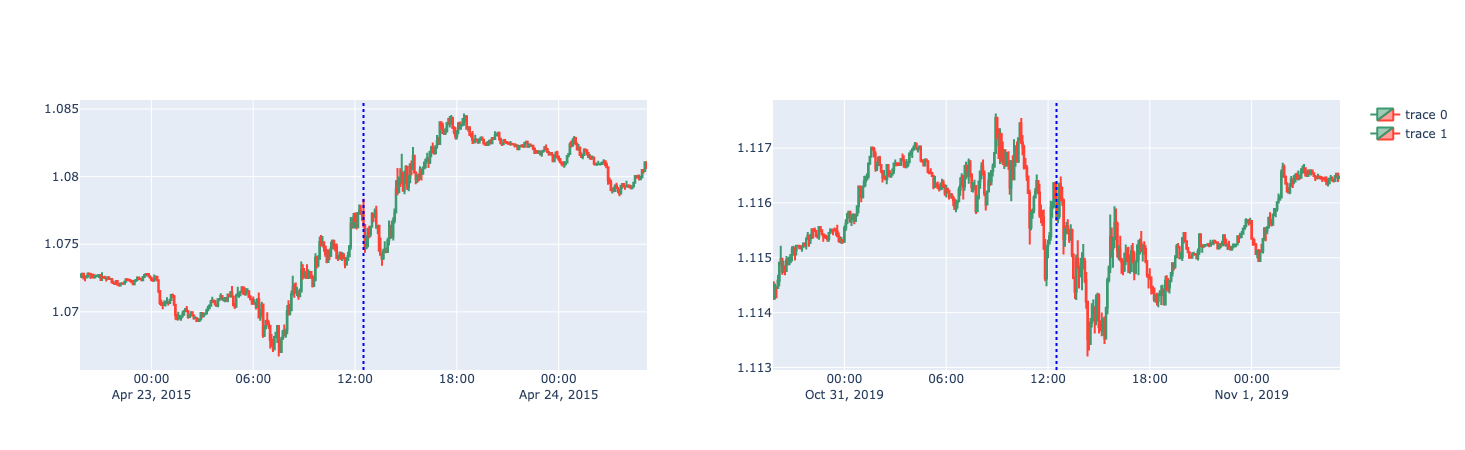

actual_value      2269
forecast_value    2250
previous_value    2256
Name: 20, dtype: object
actual_value      1935
forecast_value    1923
previous_value    1929
Name: 62, dtype: object


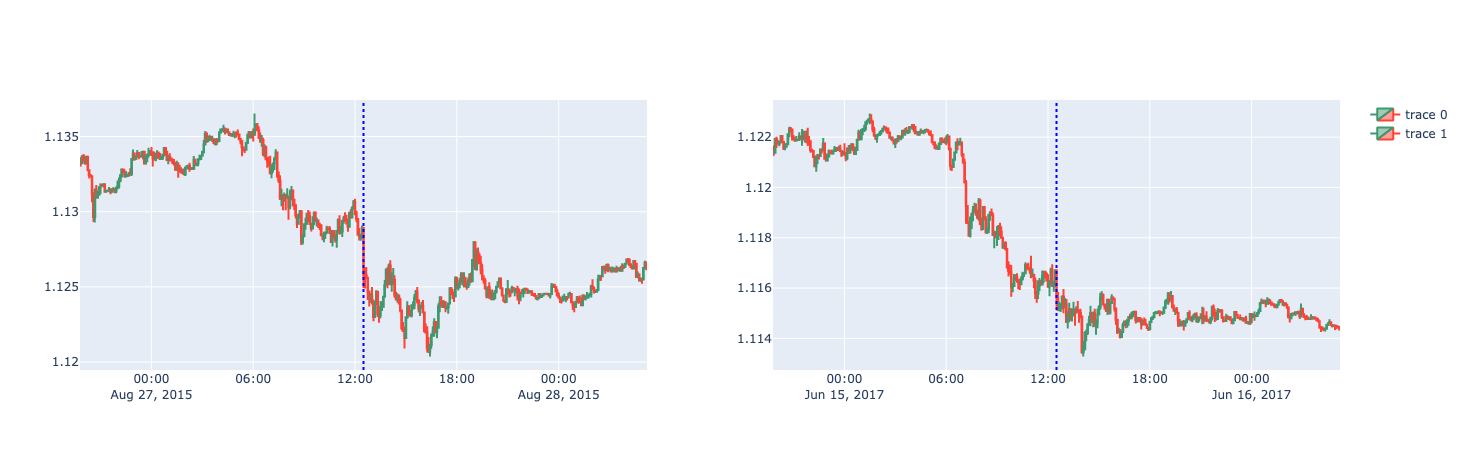

actual_value      1904
forecast_value    1882
previous_value    1868
Name: 73, dtype: object
actual_value      1755
forecast_value    1740
previous_value    1726
Name: 89, dtype: object


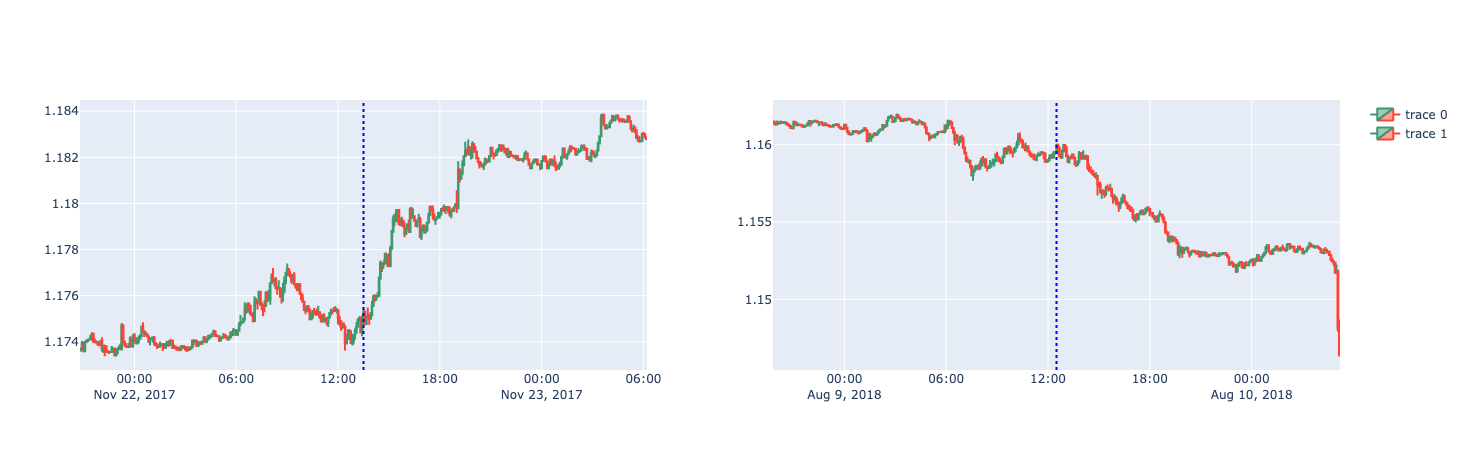

actual_value      2257
forecast_value    2250
previous_value    2266
Name: 21, dtype: object
actual_value      1954
forecast_value    1950
previous_value    1954
Name: 69, dtype: object


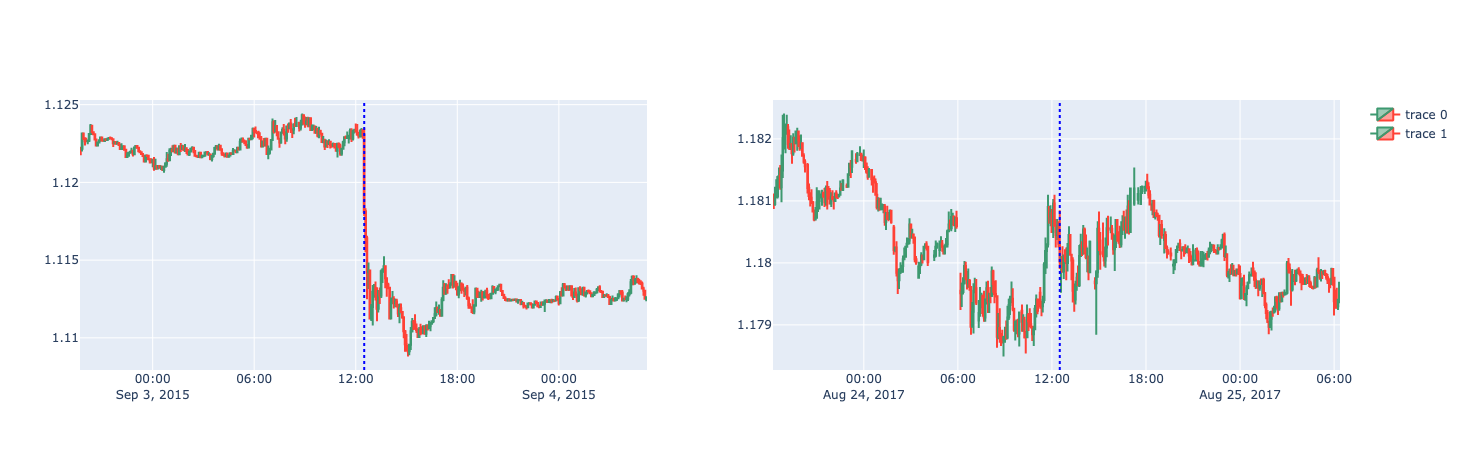

actual_value      2421
forecast_value    2400
previous_value    2404
Name: 6, dtype: object
actual_value      2036
forecast_value    2015
previous_value    2021
Name: 54, dtype: object


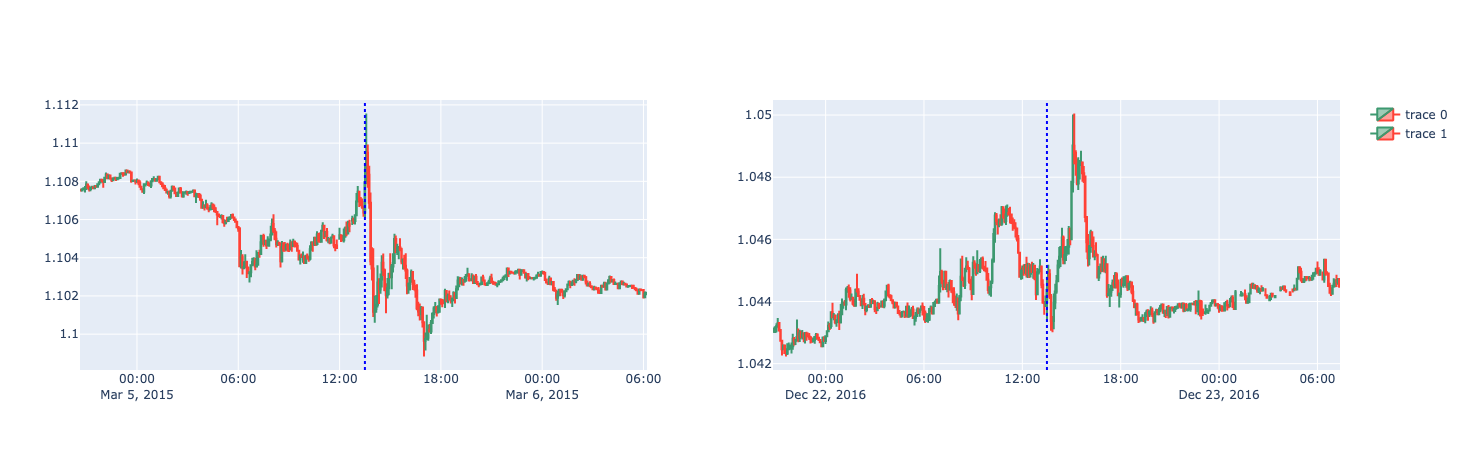

actual_value      2334
forecast_value    2248
previous_value    2265
Name: 16, dtype: object
actual_value      2043
forecast_value    2030
previous_value    1983
Name: 52, dtype: object


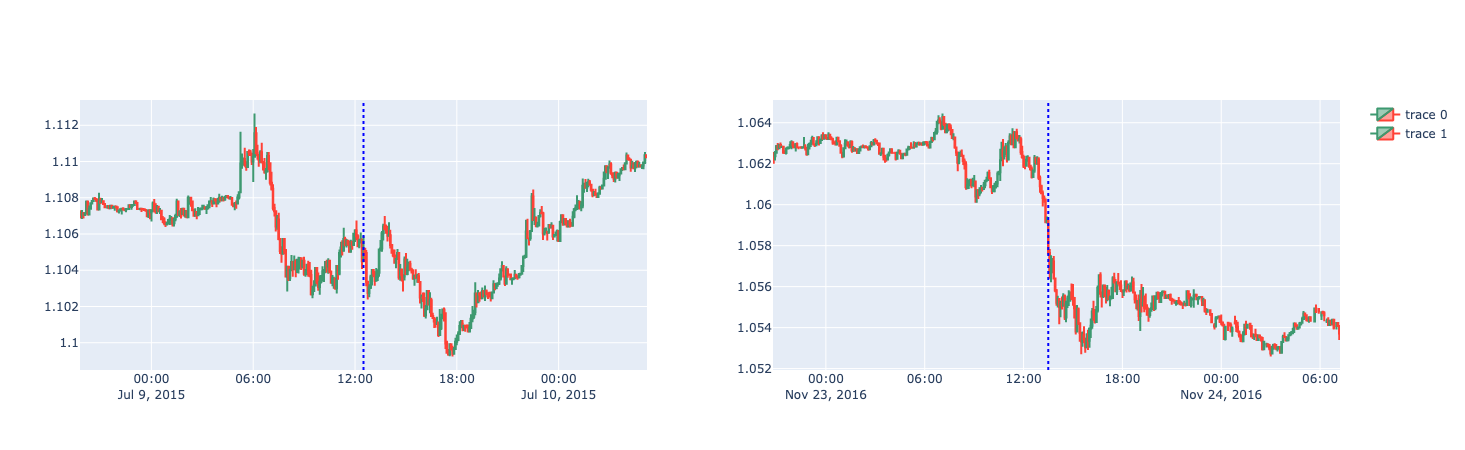

In [112]:
show_random_cases(candles, data, positiv=-1, nb_candles_to_show=400)

# Show radom candles

In [119]:
def show_random_cases(candles, nb_examples_to_show=30, nb_candles_to_show=50):
    cd = candles.copy().reset_index(drop=True)
    idx = cd.index.tolist()
    random.shuffle(idx)

    idx_to_show = idx[:nb_examples_to_show]
    
    for i, idx_candle in enumerate(idx_to_show):
        candles_to_show = cd.loc[idx_candle - nb_candles_to_show // 2 : idx_candle + nb_candles_to_show // 2]
        if i % 2 == 0:
            fig = make_subplots(rows=1, cols=2)
        
        fig.update_layout(xaxis1_rangeslider_visible=False, xaxis2_rangeslider_visible=False)

        width = 2
        color = 'rgba(46, 134, 193, 0.5)'
        fig.add_trace(go.Candlestick(x=candles_to_show['date'],
                                     open=candles_to_show['open'],
                                     high=candles_to_show['high'],
                                     low=candles_to_show['low'],
                                     close=candles_to_show['close']),
                      row=1, col= i % 2 + 1)        

        if i % 2 == 1:
            fig.show()

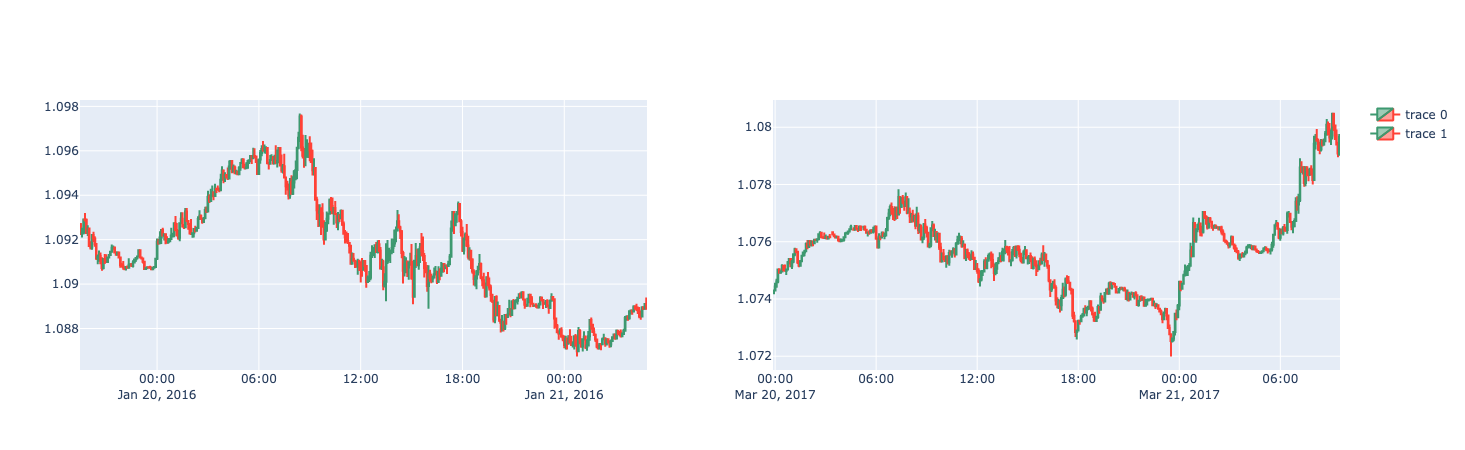

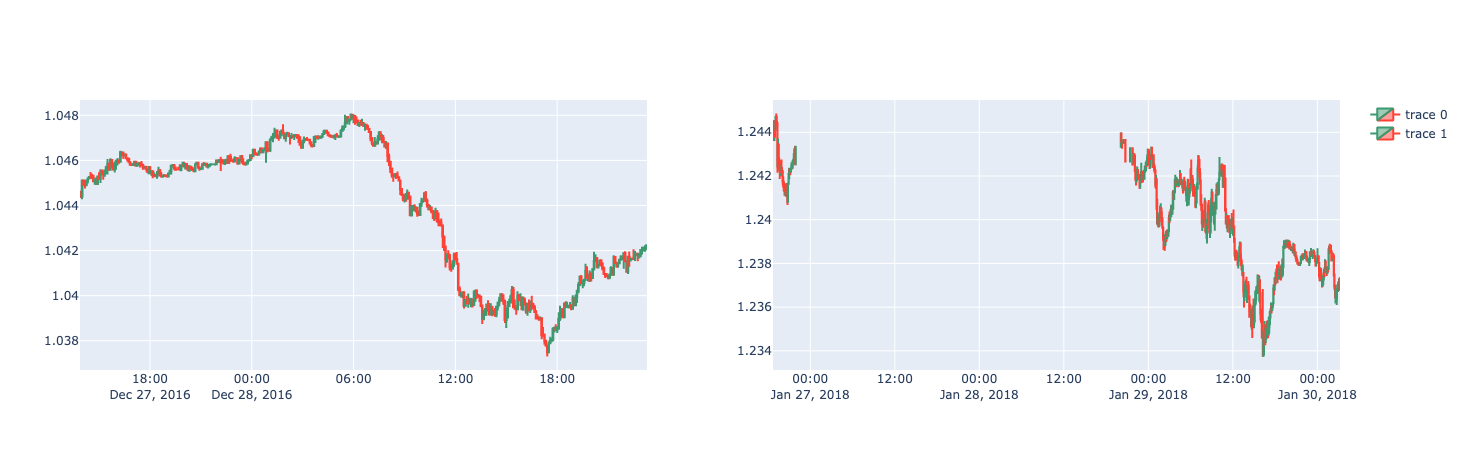

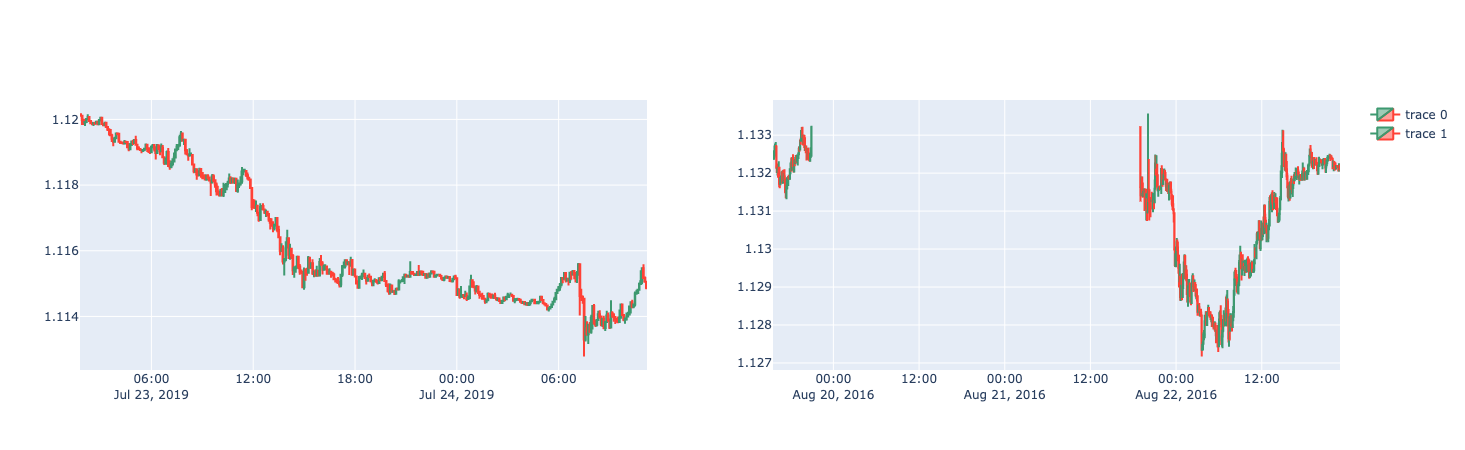

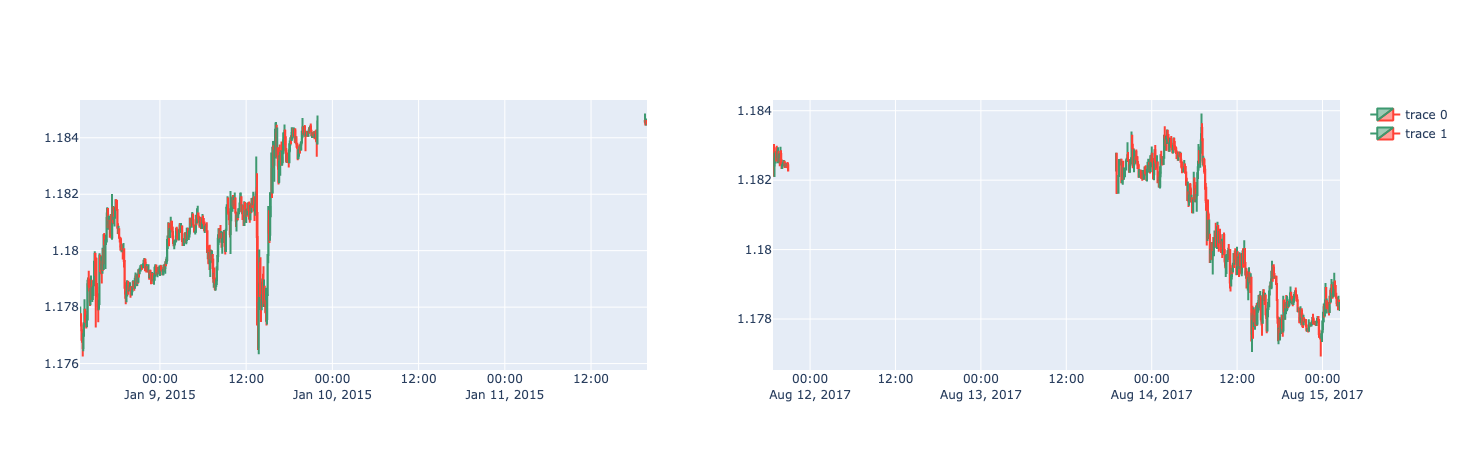

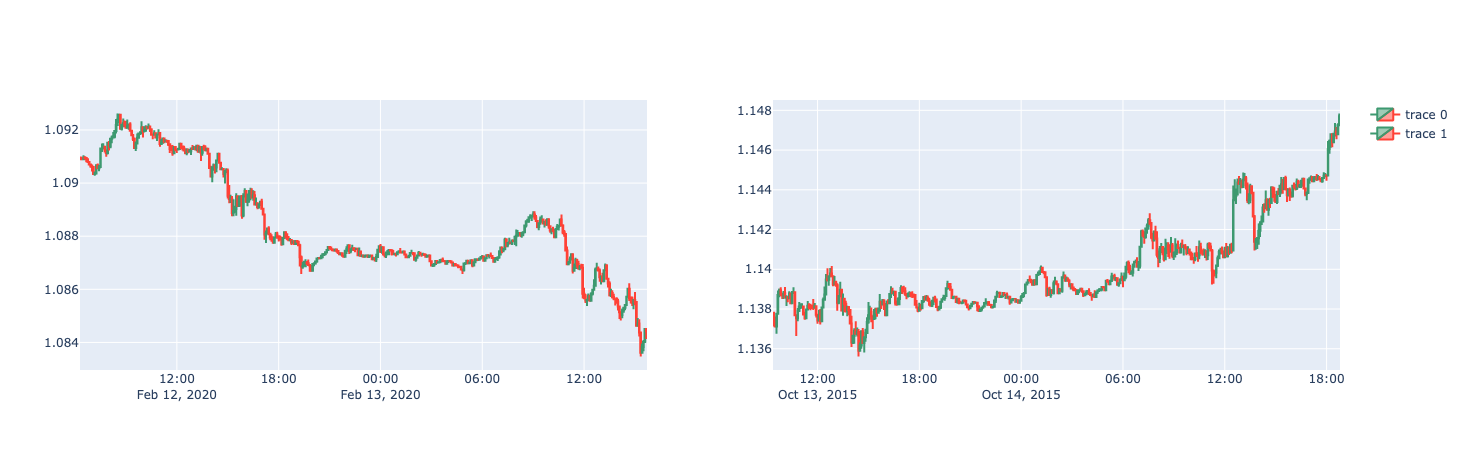

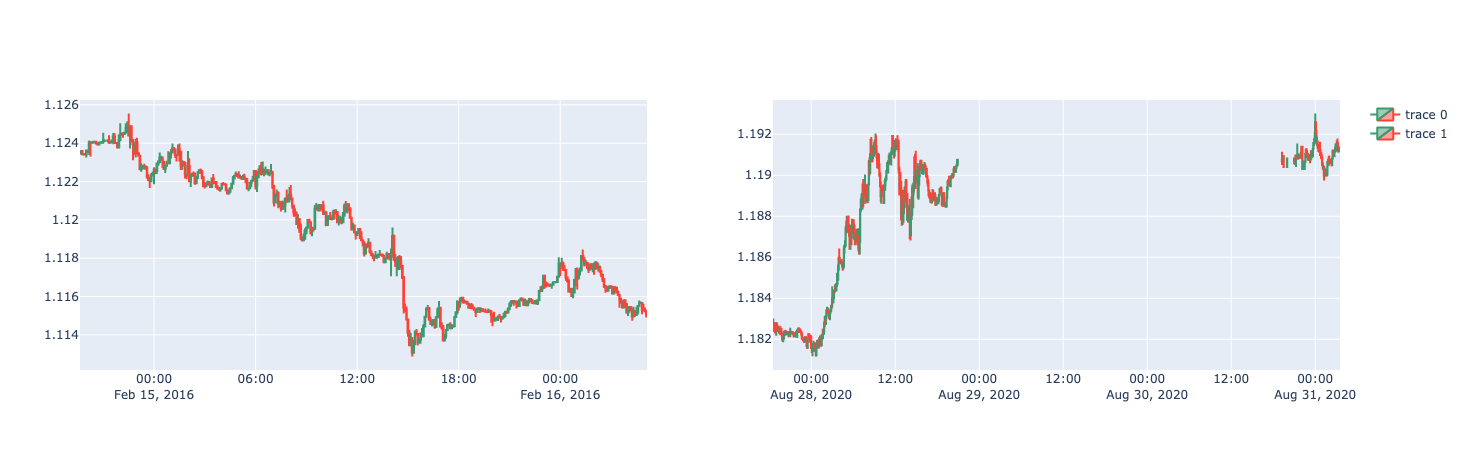

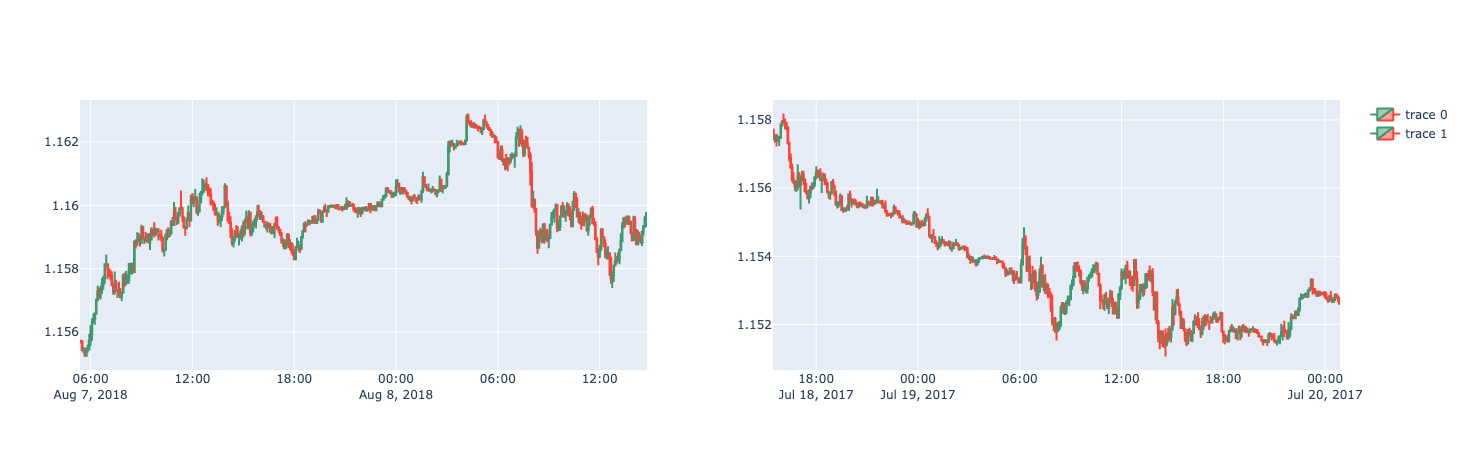

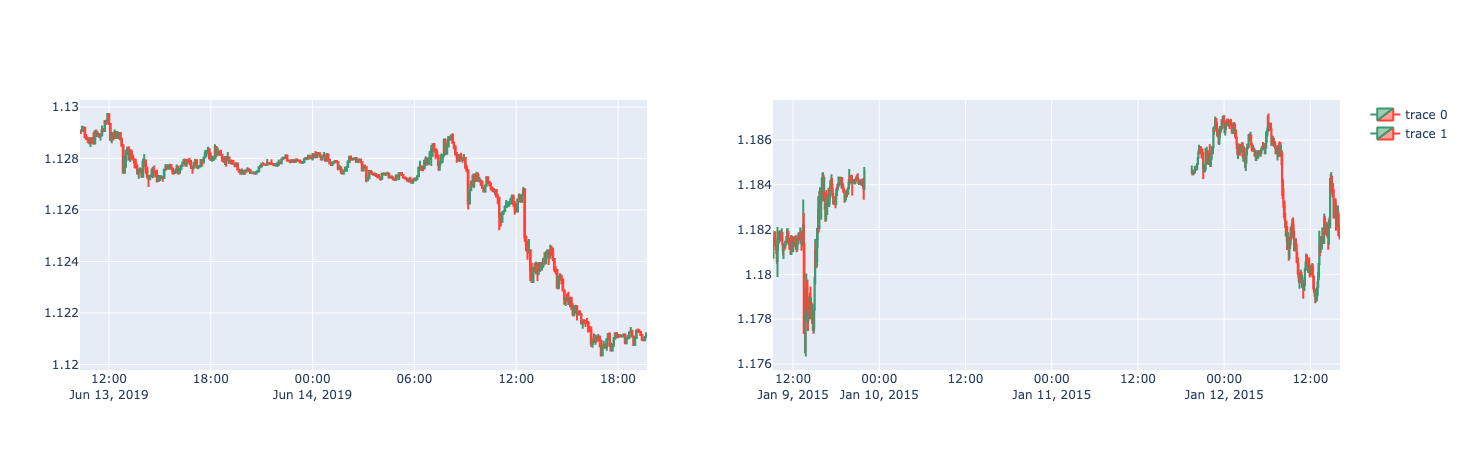

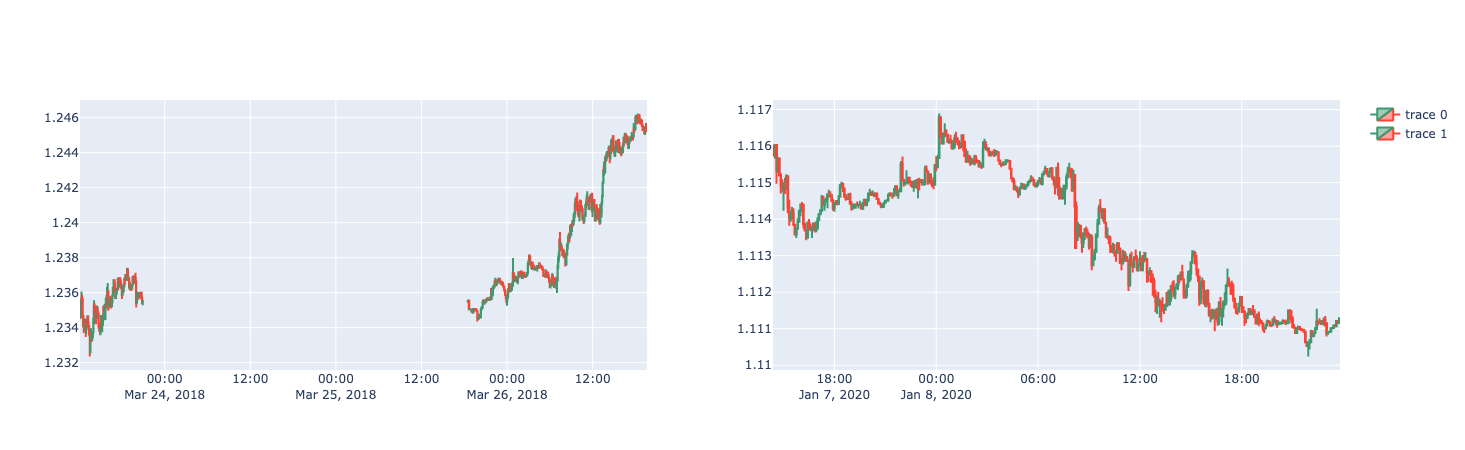

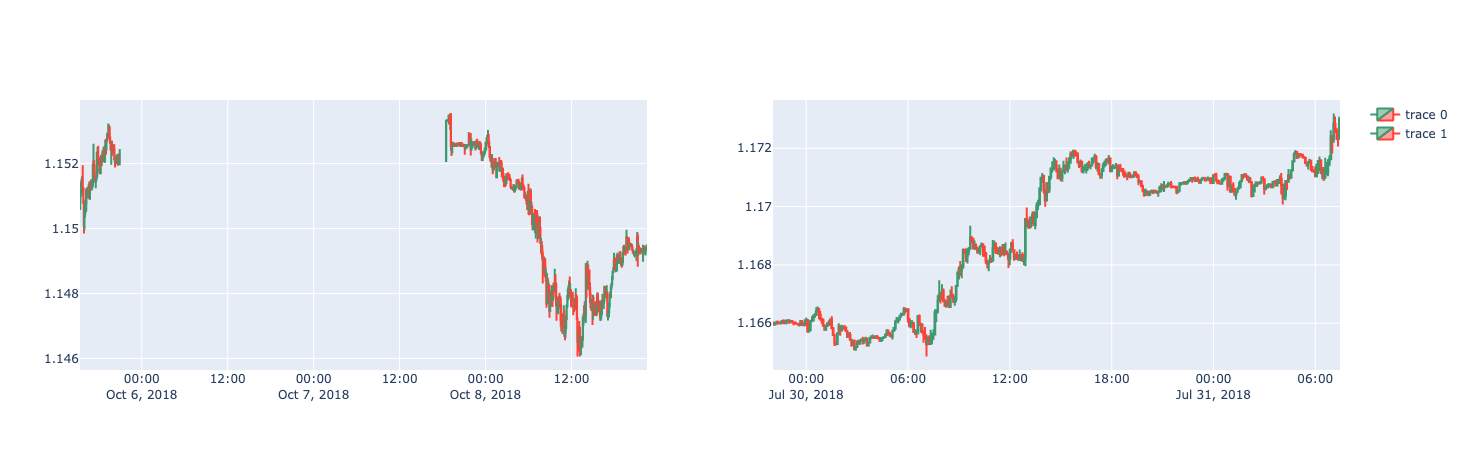

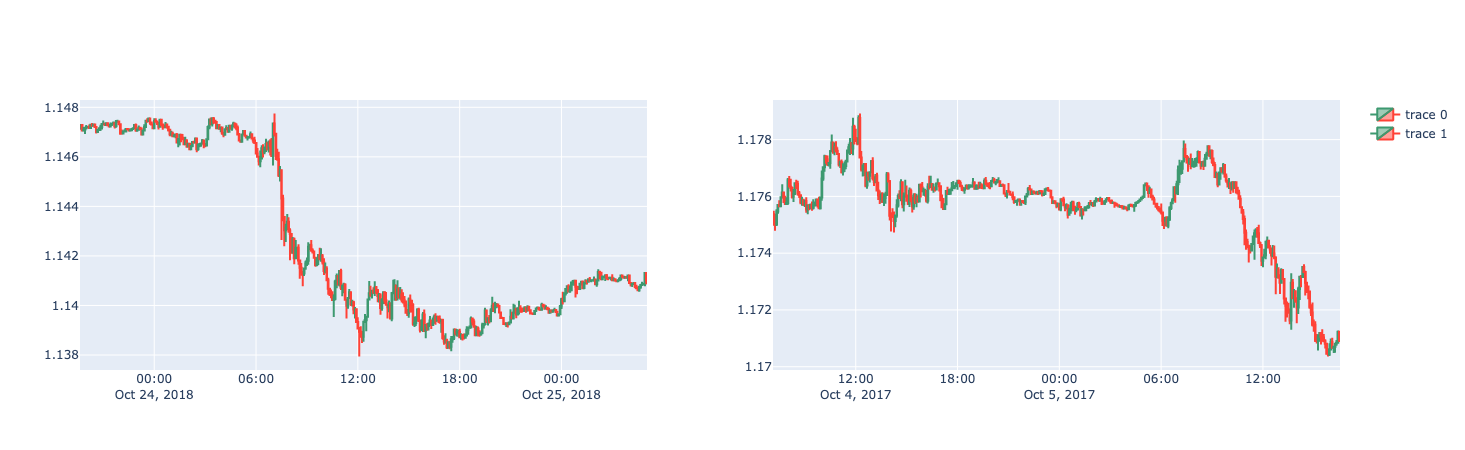

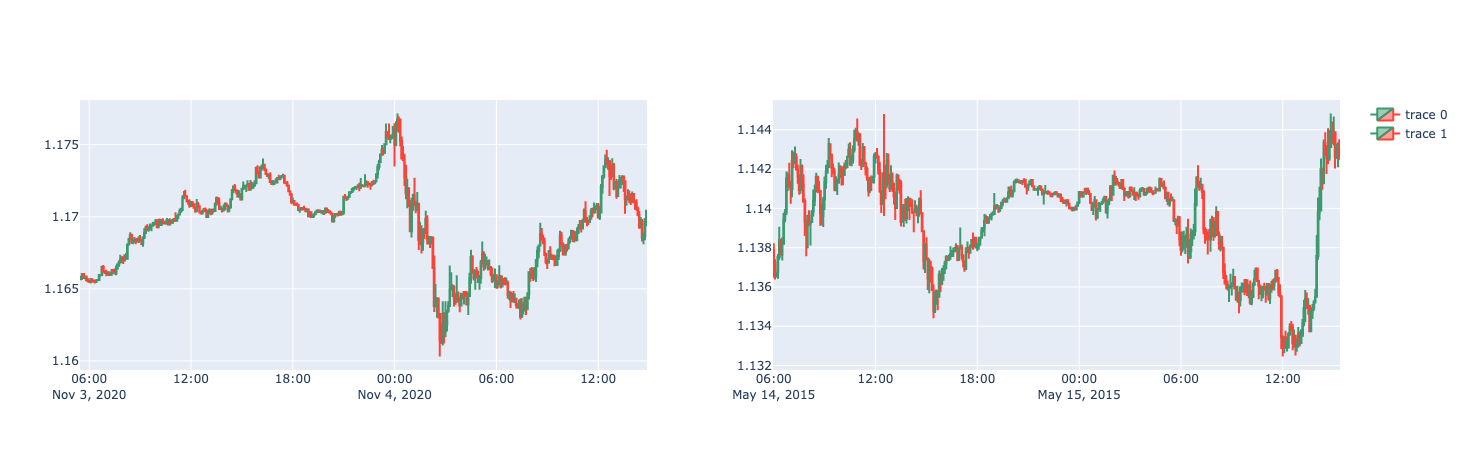

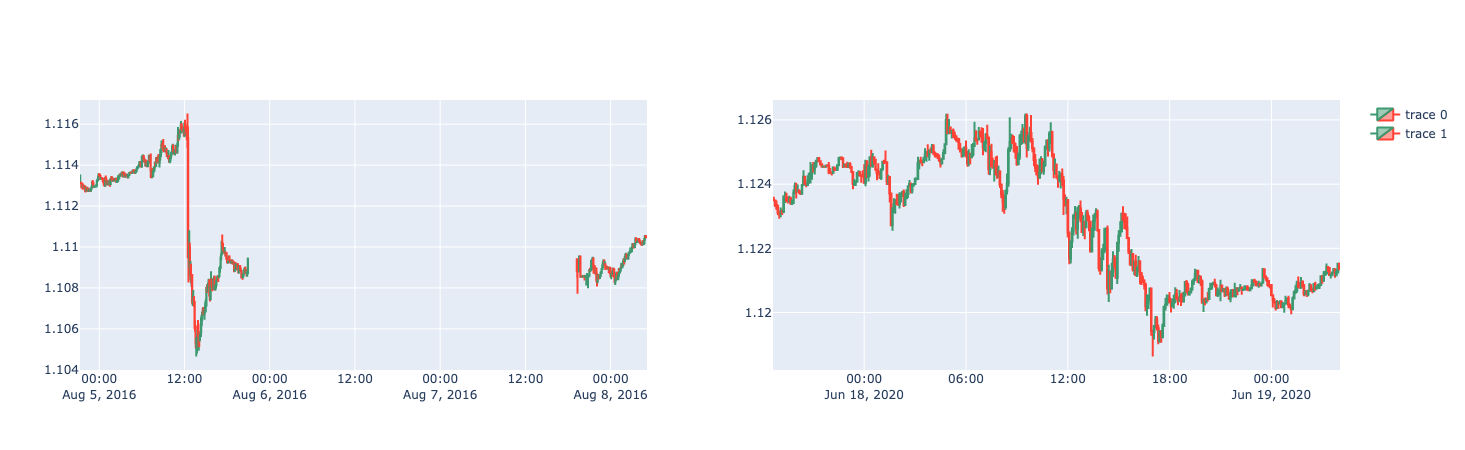

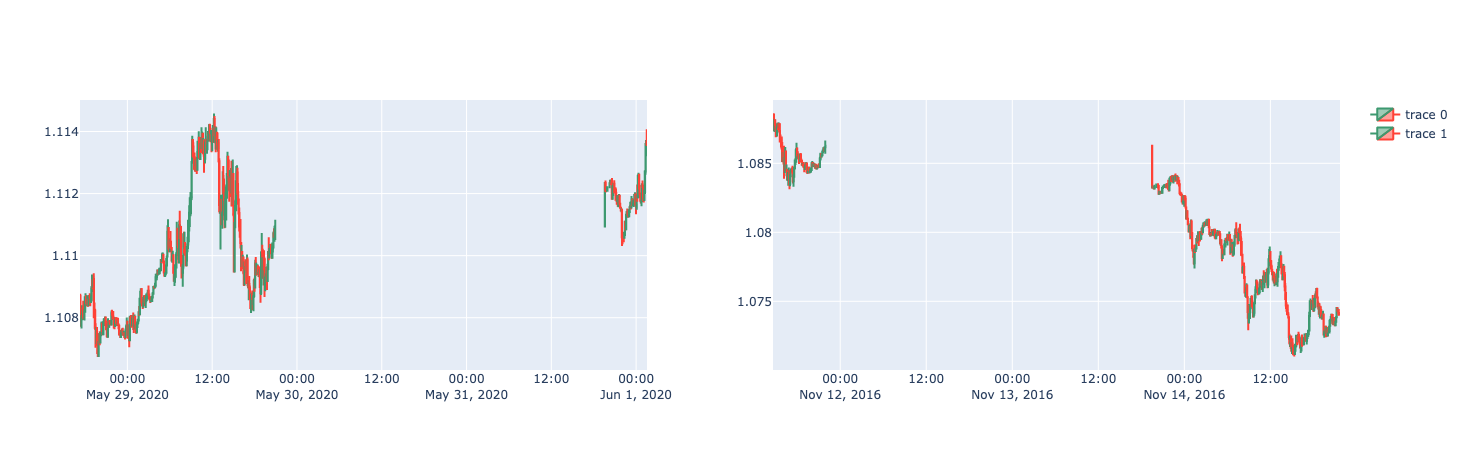

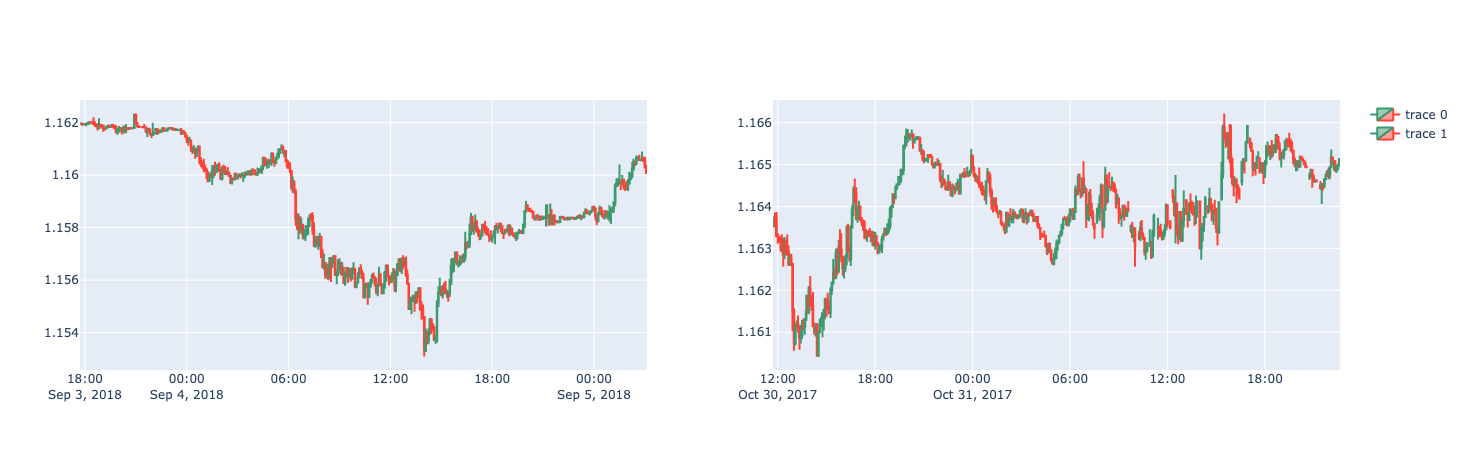

In [125]:
candles = all_candles[(all_candles['table'] == 'candle') & (all_candles['symbol'] == 'EUR/USD')]
show_random_cases(candles, nb_candles_to_show=400)

In [123]:
import yfinance as yf
pub = yf.Ticker('PUB.PA')

In [62]:
pub.earnings

Revenue   Earnings
Year                        
2017   9332000000  862000000
2018   8969000000  919000000
2019  11001000000  841000000
2020  10788000000  576000000

In [64]:
from stocknews import StockNews
sn = StockNews(['PUB.PA'], wt_key='MY_WORLD_TRADING_DATA_KEY')

In [72]:
sn.read_rss().loc[0, 'title']

"MMS USA Financing, Inc. -- Moody's changes Publicis' outlook to stable from negative"

In [70]:
sn.read_rss()

guid   stock  \
0   51afc70a-672e-307e-b8e4-b4d9ada7475f  PUB.PA   
1   fb9ad535-2b78-3b47-992f-4ef108fbb0ea  PUB.PA   
2   72bf4285-013e-3e32-b12b-94bc7978d9bb  PUB.PA   
3   62b84c54-f8b1-344b-a95a-5966dd5b1c70  PUB.PA   
4   809a3e9a-64ff-3fe2-b690-d492c9e705d6  PUB.PA   
5   3cc682a6-f1ee-36ff-95cc-1667cbddbc99  PUB.PA   
6   5ef98cbe-6671-3742-83e7-67826fc51f87  PUB.PA   
7   b2a14e8a-dba8-3160-ad29-2c7d66e01fea  PUB.PA   
8   6324c5cd-ff8b-334a-8056-1ae76c97c2f3  PUB.PA   
9   d34969f5-6ca7-3295-b0f4-14c71a1d75e1  PUB.PA   
10  cce538da-ab5c-3e73-8094-9ebaebe142f1  PUB.PA   
11  78f09855-b4d1-38dd-b0ee-6447b7337440  PUB.PA   
12  16026106-257c-371f-8786-06bdd8b5551d  PUB.PA   
13  3bbaa287-7989-3911-9b33-3da2ffc66f2e  PUB.PA   
14  7ae6b9dd-44d1-3e03-9fec-912609463251  PUB.PA   
15  f5002994-150e-3a01-8ca9-3ce2ac8c2a51  PUB.PA   
16  17c23461-9f69-31f1-b47d-ce79a9fc92bf  PUB.PA   
17  c0f83c5f-70e6-3baa-b75c-34d36b4524b8  PUB.PA   
18  536fc5c0-2094-3f17-ad05-a8c30545529a  PUB.PA   
19  473dca9c-f91d-3f45-87f1-ce1db03ff533  PUB.PA   

                                                title  \
0   MMS USA Financing, Inc. -- Moody's changes Pub...   
1   UPDATE 2-Ad giant WPP pledges net zero emissio...   
2        Publicis Groupe : First Quarter 2021 Revenue   
3    U.S. digital ads spur Publicis' return to growth   
4   Publicis Groupe S.A.: 2020 Universal Registrat...   
5   Publicis Deal With Trade Desk Aims to Target A...   
6   Publicis, The Trade Desk partner as ad trackin...   
7             Publicis Groupe: Full Year 2020 Results   
8   CORRECTING and REPLACING: Publicis Groupe Half...   
9   Publicis Groupe Half-year Financial Statement ...   
10  Publicis Groupe Announces the Appointment of M...   
11        Publicis Groupe: Third Quarter 2020 Revenue   
12  Publicis beats market expectations for second ...   
13  Publicis Groupe S.A.: Adjustement to the Exerc...   
14  Mike Bartholomew Shares 5 tips to Help Budding...   
15  Publicis Groupe S.A.: Overview of the Share Bu...   
16  Publicis Groupe S.A.: Half-Year 2020 Financial...   
17  MMS USA Financing, Inc. -- Moody's announces c...   
18  Facebook Ad Boycott To Continue, Publicis Pred...   
19  Publicis beats dire market expectations amid w...   

                                              summary  \
0   Rating Action: Moody's changes Publicis' outlo...   
1   WPP said on Thursday it planned to make the wo...   
2   First Quarter 2021 Revenue - Returning to grow...   
3   Publicis, the world's third-largest advertisin...   
4                2020 Universal Registration Document   
5   Publicis PUBGY and Trade Desk TTD said on Thur...   
6   France's Publicis said on Thursday it has part...   
7   Bonjour, Veuillez trouver ci-dessous le lien p...   
8   Publicis Groupe Half-year Financial Statement ...   
9   Publicis Groupe half-year financial statement ...   
10  Appointment of Michel-Alain Proch as Groupe’s ...   
11  Third Quarter 2020 Revenue  -Confirming the re...   
12  Publicis, the world's third-biggest advertisin...   
13      ADJUSTEMENT TO THE EXERCISE PARITY OF THE BSA   
14  With top advertising companies like WPP Plc (N...   
15                Share buy back program Shareholders   
16          Half-Year 2020 Financial Report available   
17  Announcement of Periodic Review: Moody's annou...   
18  Facebook Inc (NASDAQ: FB) advertising boycott ...   
19  Publicis, the world's third-biggest advertisin...   

                          published             p_date  sentiment_summary  \
0   Wed, 28 Apr 2021 09:41:08 +0000  PUB.PA_2021-04-28             0.3182   
1   Thu, 22 Apr 2021 09:08:55 +0000  PUB.PA_2021-04-22             0.2023   
2   Thu, 15 Apr 2021 09:01:00 +0000  PUB.PA_2021-04-15             0.9995   
3   Thu, 15 Apr 2021 05:32:34 +0000  PUB.PA_2021-04-15             0.8979   
4   Fri, 09 Apr 2021 18:28:00 +0000  PUB.PA_2021-04-09             0.0000   
5   Thu, 08 Apr 2021 18:50:00 +0000  PUB.PA_2021-04-08             0.0000   
6   Thu,